In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import scipy.integrate as integrate

import torch
import torchquad


In [2]:
# may want to revisit these choices
integrator = torchquad.Trapezoid()
N_integrator = 500


In [3]:
# ansatz helper functions

# g_coeffs: M x N matrix such that g = sum_{m, n} g_mn t^n alpha ^m
    # 1st row is g* term

def f(t, alpha, g_coeffs, mstar):
    M,N = g_coeffs.shape
    g_star = alpha**mstar * sum([g_coeffs[0,n]*torch.pow(t,n) for n in range(N) ])
    g_higher = sum([alpha**(mstar + m) * g_coeffs[m,n]*torch.pow(t,n) for n in range(N) for m in range(1,M) ])
    return g_star*torch.exp(-g_higher)


def q(t, alpha, g_coeffs, mstar):

    f_of_t = lambda tt: f(tt, alpha, g_coeffs, mstar)
    
    intfunc = lambda tt: integrator.integrate(f_of_t, dim=1, N=N_integrator, integration_domain=[[0, tt]])

    # vmap does not like the torch integrator but it's running decently quickly now...
    #vec_int = torch.func.vmap(intfunc)
    #exp_term = vec_int(t)

    exp_term = torch.tensor([intfunc(tt) for tt in t])

    return f_of_t(t)*torch.exp(-exp_term)


tensor([[1, 2, 0],
        [4, 0, 0]])


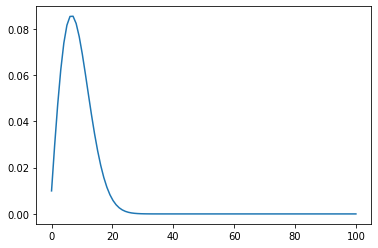

In [28]:

g_coeffs = torch.tensor(np.array([[1, 2, 0], [4,0,0]]))
print(g_coeffs)
t = torch.linspace(0, 100, 100)


plt.figure()
plt.plot(t, q(t, 0.1, g_coeffs, 2))
plt.show()

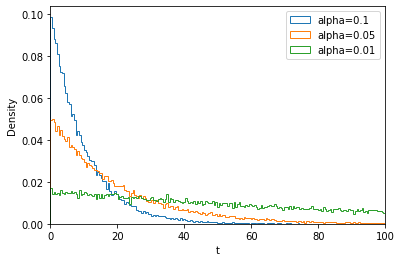

In [5]:
# choose data distribution

N_data = 50000 # number of data samples per epoch to draw
xlim = 100
nbins = 200

def get_data(N, alpha):

    return np.random.exponential(size=N, scale = (1.0/alpha))

    #return np.random.triangular(size = N, left = 0, right = 4, mode = 1+alpha)

    #x = np.linspace(3, 7, N)
    #delta = np.random.uniform(-1, 1, x.size)
    #y = 0.4*x + delta

    return y


plt.figure()
for alpha in [0.1, 0.05, 0.01]:
    plt.hist( get_data(N_data, alpha), bins = np.linspace(0, xlim, nbins), histtype = "step", label = f"alpha={alpha}", density = True)
plt.legend()
plt.xlim(0, xlim)
plt.xlabel("t")
plt.ylabel("Density")
plt.show()

In [22]:
# Initialize the g_coefficients

mstar = 1
g_coeffs_to_fit = torch.rand(size=(3,2)).float()

#g_coeffs_to_fit = torch.tensor(np.array([[0.5, 0, 0], [0,0,0]])).float()

print(g_coeffs_to_fit)

tensor([[0.1634, 0.8968],
        [0.9089, 0.3499],
        [0.1162, 0.0367]])


In [23]:
from torch.autograd.functional import jacobian


epochs = 100



# TODO: results may be sensitive to the binning choice...
t_bins = torch.linspace(0, xlim, nbins)
t_bin_centers = 0.5*(t_bins[1:] + t_bins[:-1])

def train(epochs, lr = 1e-3):

    g_coeffs_to_fit.requires_grad_()
    optimizer = torch.optim.AdamW([g_coeffs_to_fit], lr=lr)

    MSE_criterion = torch.nn.MSELoss()

    losses_MSE, losses_deriv = [], []

    for epoch in  tqdm(range(epochs)):

        optimizer.zero_grad()

        # generate a random alpha for the epoch
        loc_alpha = torch.distributions.Exponential(1 / 0.118).sample()
        # alpha = torch.rand(batch_conditional)

    
        # generate training data
        loc_data = get_data(N_data, loc_alpha)
        # histogram
        loc_data_pdf, _ = np.histogram(loc_data, bins = t_bins, density = True)

        """
        plt.figure()
        plt.hist(loc_data, bins = t_bins, density = True)
        plt.plot(t_bin_centers.detach().cpu().numpy(), loc_data_pdf)
        plt.plot(t_bin_centers.detach().cpu().numpy(), loc_ansatz.detach().cpu().numpy())
        plt.title(loc_alpha)
        plt.show()
        """

        loc_data_pdf = torch.tensor(loc_data_pdf)

        # calculate taylor components of the ansatz
        helper_ansatz = lambda a: q(t_bin_centers, a, g_coeffs_to_fit, mstar)

        # q(0)
        # TODO if mstar > m, then we only need to calculate the d^m derivative since all lower ones will be zero
        loc_ansatz_0 = helper_ansatz(0)
        
        # dq / d alpha
        
        loc_ansatz_1 = torch.autograd.functional.jacobian(helper_ansatz, torch.tensor([0.0]), create_graph=True, vectorize=False).reshape(-1,)
        # TODO higher derivatives

        loc_ansatz = loc_ansatz_0 + loc_alpha*loc_ansatz_1

        loss = MSE_criterion(loc_data_pdf.float(), loc_ansatz.float())

        loss.backward()
        optimizer.step()

        losses_MSE.append(loss.detach().cpu().numpy())
        #losses_deriv.append(loss_deriv.detach().cpu().numpy())



    return losses_MSE, losses_deriv

losses_MSE, losses_deriv = train(epochs, lr = 1)


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


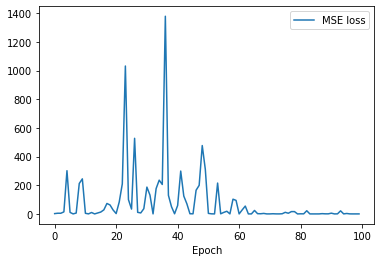

In [24]:
plt.figure()

plt.plot(losses_MSE, label = "MSE loss")
#plt.plot(losses_deriv, label = "deriv loss")
plt.legend()

plt.xlabel("Epoch")


plt.show()

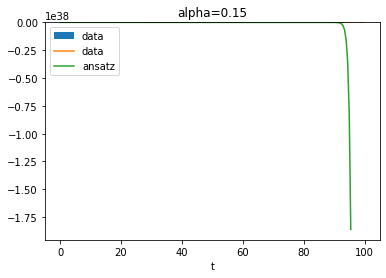

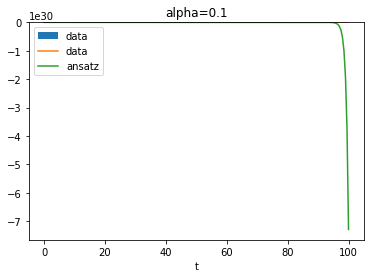

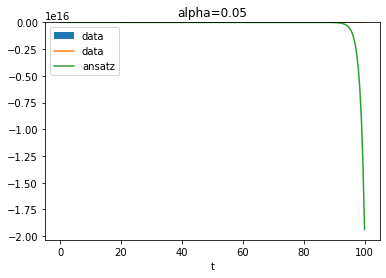

In [25]:
for alpha in [0.15, 0.1, 0.05]:
    
     
    # generate training data
    loc_data = get_data(N_data, alpha)
    # histogram
    loc_data_pdf, _ = np.histogram(loc_data, bins = t_bins, density = True)
    
    
    
    tt = torch.linspace(0, xlim, 200)
    loc_ansatz = q(tt , alpha, g_coeffs_to_fit, mstar)
    
    plt.figure()
    plt.hist(loc_data, bins = t_bins, density = True, label = "data")
    plt.plot(t_bin_centers.detach().cpu().numpy(), loc_data_pdf, label = "data")
    plt.plot(tt , loc_ansatz.detach().cpu().numpy(), label = "ansatz")
    plt.legend()
    plt.xlabel("t")
    plt.title(f"alpha={alpha}")
    plt.show()

In [26]:
print(g_coeffs_to_fit)

tensor([[-0.3246, -0.1481],
        [ 0.3327,  0.1281],
        [ 0.0425,  0.0134]], requires_grad=True)
